# Titanic Survival Part 3: Training Classifiers for Accuracy

In Part 1 of this project I conduct Exploratory Data Analysis (EDA) of the Titanic training data using R. This exploration can be found [here.](http://rpubs.com/BigBangData/512981)

In Part 2 I continue the exploration using Python and building a couple of basic models. This is not intended as the goal of the competition, just an exploration of modeling in Python.

In Part 3 (this notebook) I create a pre-processing pipeline and train several models in Python using the scikit-learn module, and submit my predictions to the competition.


In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
import time

dt_object = datetime.fromtimestamp(time.time())
dt_object = str(dt_object).split('.')[0]

Date, Time = dt_object.split(' ')
print('Revised on: ' + Date)

Revised on: 2020-01-02


## Pre-Processing

In [1]:
# import modules
import pandas as pd
import numpy as np

# custom pre-processing module
import processing_pipeline as pp  

# load datasets
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

# separate target from predictors in training set
survived_labels = train_data['Survived'].copy()
train_data_nolabel = train_data.drop('Survived', axis=1)

# get processed training data and labels
X = pp.process_train(train_data_nolabel)
y = survived_labels.to_numpy()

## Modeling

### Stochastic Gradient Descent

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
     
sgd_clf = SGDClassifier(random_state=42)
    
accuracies = cross_val_score(estimator=sgd_clf, X=X, y=y, cv=100)

In [3]:
mn, sd = round(accuracies.mean(),4), round(accuracies.std(),4)
mn, sd

(0.7824, 0.1362)

As seen in the previous notebook, the SDG model is too variable.

### Random Forests

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import pickle

A grid search shows which are the best parameters for the highest accuracy across a range of values. Here we construct a 20 x 2 x 2 = 80-parameter grid search:


In [19]:
# load pickled model so as to skip the grid search in future notebook runs
try:
    grid_search = pickle.load(open('./RandomForest_GridSearch.sav', 'rb'))
except FileNotFoundError as e:
    num_estimators = list(range(50,5000,250))
    
    grid_param = {
        'n_estimators': num_estimators,
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False]
    }
    
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=grid_param,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1)
    
    # running the grid search: this takes time...
    grid_search.fit(X,y)
    
    # pickle the model for future ease
    pickle.dump(grid_search, open('./RandomForest_GridSearch.sav', 'wb'))

In [21]:
# best arameters and the best accuracy
grid_search.best_params_ , round(grid_search.best_score_, 4)

({'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 300}, 0.8193)

In [22]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_criterion', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [23]:
cv_res1 = grid_search.cv_results_['split0_test_score']
cv_res2 = grid_search.cv_results_['split1_test_score']
cv_res3 = grid_search.cv_results_['split2_test_score']
cv_res4 = grid_search.cv_results_['split3_test_score']
cv_res5 = grid_search.cv_results_['split4_test_score']

In [52]:
grid_search.cv_results_['rank_test_score']

array([21, 27, 22, 27, 22, 22, 27, 40, 34, 27, 34, 34, 22, 22, 27, 27, 34,
       34, 27, 34,  3,  1,  1,  3,  3, 16, 16, 10, 10, 16, 16, 16,  3,  3,
       10, 10, 10, 10,  3,  3, 80, 53, 45, 68, 68, 68, 45, 42, 42, 45, 53,
       45, 53, 53, 53, 53, 53, 68, 77, 77, 79, 41, 53, 42, 45, 53, 68, 68,
       53, 53, 45, 45, 53, 45, 53, 53, 68, 68, 53, 68], dtype=int32)

In [28]:
param_arr = grid_search.cv_results_['params']

bootstraps = []
criteria = []
estimators = []
for i in param_arr:
    bootstraps.append(i['bootstrap'])
    criteria.append(i['criterion'])
    estimators.append(i['n_estimators'])

In [50]:
data = pd.DataFrame(list(zip(bootstraps, criteria, estimators,cv_res1,cv_res2,cv_res3,cv_res4,cv_res5))
                    ,columns = ['bootstrap','criterion','n_estimators','cv1','cv2','cv3','cv4','cv5'])

In [107]:
boot_gini = data[(data.bootstrap == True)  & (data.criterion == 'gini')].copy()
boot_entr = data[(data.bootstrap == True)  & (data.criterion == 'entropy')].copy()
noot_gini = data[(data.bootstrap == False)  & (data.criterion == 'gini')].copy()
noot_entr = data[(data.bootstrap == False)  & (data.criterion == 'entropy')].copy()

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

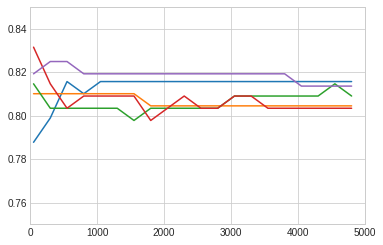

In [117]:
x = list(boot_gini['n_estimators'])
Y1 = list(boot_gini['cv1'])
Y2 = list(boot_gini['cv2'])
Y3 = list(boot_gini['cv3'])
Y4 = list(boot_gini['cv4'])
Y5 = list(boot_gini['cv5'])

plt.axis([0, 5000, .75, .85])
plt.plot(x, Y1)
plt.plot(x, Y2)
plt.plot(x, Y3)
plt.plot(x, Y4)
plt.plot(x, Y5)
plt.show()

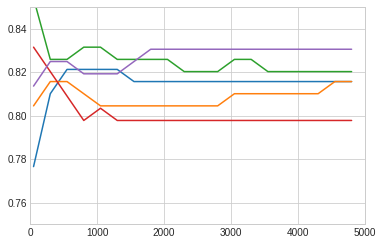

In [118]:
x = list(boot_entr['n_estimators'])
Y1 = list(boot_entr['cv1'])
Y2 = list(boot_entr['cv2'])
Y3 = list(boot_entr['cv3'])
Y4 = list(boot_entr['cv4'])
Y5 = list(boot_entr['cv5'])

plt.axis([0, 5000, .75, .85])
plt.plot(x, Y1)
plt.plot(x, Y2)
plt.plot(x, Y3)
plt.plot(x, Y4)
plt.plot(x, Y5)
plt.show()

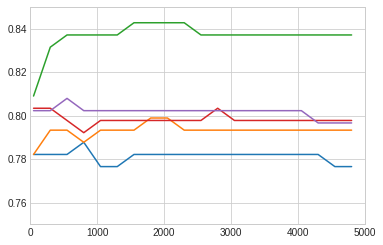

In [119]:
 x = list(noot_gini['n_estimators'])
Y1 = list(noot_gini['cv1'])
Y2 = list(noot_gini['cv2'])
Y3 = list(noot_gini['cv3'])
Y4 = list(noot_gini['cv4'])
Y5 = list(noot_gini['cv5'])

plt.axis([0, 5000, .75, .85])
plt.plot(x, Y1)
plt.plot(x, Y2)
plt.plot(x, Y3)
plt.plot(x, Y4)
plt.plot(x, Y5)
plt.show()

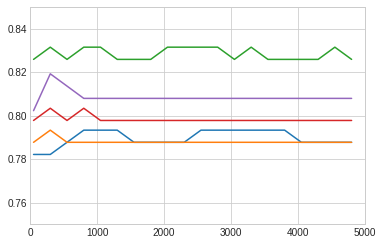

In [120]:
 x = list(noot_entr['n_estimators'])
Y1 = list(noot_entr['cv1'])
Y2 = list(noot_entr['cv2'])
Y3 = list(noot_entr['cv3'])
Y4 = list(noot_entr['cv4'])
Y5 = list(noot_entr['cv5'])

plt.axis([0, 5000, .75, .85])
plt.plot(x, Y1)
plt.plot(x, Y2)
plt.plot(x, Y3)
plt.plot(x, Y4)
plt.plot(x, Y5)
plt.show()

## feature selection?

In [11]:
# best model
forest_clf = RandomForestClassifier(bootstrap=True,
                                    criterion='entropy',
                                    n_estimators=300,
                                    random_state=42)

In [13]:
accuracies = cross_val_score(forest_clf, X, y, cv=10)
mn, sd = round(accuracies.mean(),4), round(accuracies.std(),4)
mn, sd

(0.8249, 0.0308)

In [21]:
grid_param = {
    'n_estimators': [x for x in range(200, 410, 10)],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [22]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=grid_param,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

In [23]:
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bo

In [24]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 290}


In [25]:
best_result = grid_search.best_score_
print(best_result)

0.8204264870931538


In [30]:
grid_param = {
    'n_estimators': [x for x in range(280, 310)],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=grid_param,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

In [31]:
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...te=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [T

In [32]:
best_parameters = grid_search.best_params_
best_parameters

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 295}

In [33]:
best_result = grid_search.best_score_
best_result

0.8215488215488216

In [34]:
grid_param = {
    'n_estimators': [295, 1500, 2000, 3000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [35]:

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=grid_param,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

In [36]:
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bo

In [37]:
grid_search.best_params_ , grid_search.best_score_

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 295}

In [40]:
means = []
sds = []

for i in [x for x in range(250, 350, 5)]:
    
    forest_clf = RandomForestClassifier(bootstrap=True,
                                        criterion='entropy',
                                        n_estimators=i,
                                        random_state=42)
    
    accuracies = cross_val_score(forest_clf, X, y, cv=10)
    
    means.append(round(accuracies.mean(),4))
    sds.append(round(accuracies.std(),4))

In [73]:
data = pd.DataFrame(list(zip([x for x in range(250,350,5)], means, sds)), 
             columns=['n_est','means','stdevs'])

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

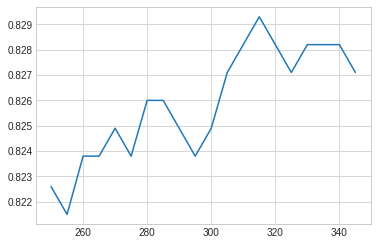

In [102]:
x = np.array(data['n_est'])
Y = np.array(data['means'])
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)

In [103]:
# creating a CI
for i in range(len(data)):
    data.loc[i, 'upper'] = data.loc[i, 'means'] + 1.965*data.loc[i, 'stdevs']
    data.loc[i, 'lower'] = data.loc[i, 'means'] - 1.965*data.loc[i, 'stdevs']

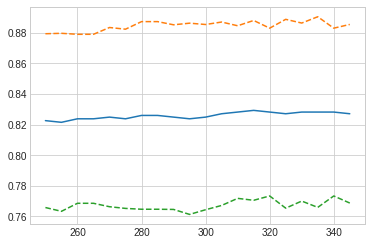

In [104]:
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)
plt.plot(x, np.array(data['upper']), linestyle='dashed')
plt.plot(x, np.array(data['lower']), linestyle='dashed')

In [111]:
means = []
sds = []

for i in list(range(100,1100,100)):
    
    forest_clf = RandomForestClassifier(bootstrap=True,
                                        criterion='entropy',
                                        n_estimators=i,
                                        random_state=42)
    
    accuracies = cross_val_score(forest_clf, X, y, cv=10)
    
    means.append(round(accuracies.mean(),4))
    sds.append(round(accuracies.std(),4))

In [113]:
indices = list(range(100,1100,100))
data = pd.DataFrame(list(zip(indices, means, sds)), 
             columns=['n_est','means','stdevs'])

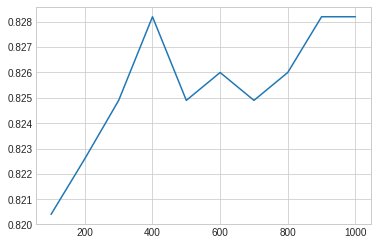

In [115]:
x = np.array(data['n_est'])
Y = np.array(data['means'])
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)

In [116]:
# creating a CI
for i in range(len(data)):
    data.loc[i, 'upper'] = data.loc[i, 'means'] + 1.965*data.loc[i, 'stdevs']
    data.loc[i, 'lower'] = data.loc[i, 'means'] - 1.965*data.loc[i, 'stdevs']

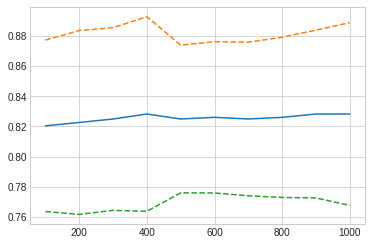

In [117]:
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)
plt.plot(x, np.array(data['upper']), linestyle='dashed')
plt.plot(x, np.array(data['lower']), linestyle='dashed')

In [4]:
index = list(range(295,6195,295))

means = []
sds = []

for i in index:
    
    forest_clf = RandomForestClassifier(bootstrap=True,
                                        criterion='entropy',
                                        n_estimators=i,
                                        random_state=42)
    
    accuracies = cross_val_score(forest_clf, X, y, cv=10)
    
    means.append(round(accuracies.mean(),4))
    sds.append(round(accuracies.std(),4))

data = pd.DataFrame(list(zip(index, means, sds)), 
             columns=['n_est','means','stdevs'])

for i in range(len(data)):
    data.loc[i, 'upper'] = data.loc[i, 'means'] + 1.965*data.loc[i, 'stdevs']
    data.loc[i, 'lower'] = data.loc[i, 'means'] - 1.965*data.loc[i, 'stdevs']

x = np.array(data['n_est'])
Y = np.array(data['means'])
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)

fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)
plt.plot(x, np.array(data['upper']), linestyle='dashed')
plt.plot(x, np.array(data['lower']), linestyle='dashed')